In [1]:
import gym
from gym import spaces
import numpy as np
from google.colab import widgets
import time
import random
from collections import deque
import copy
from statistics import mean
from itertools import count
from collections import namedtuple
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# **Cart Pole Environment**

In [2]:
env = gym.make('CartPole-v1')

In [3]:
print("There are {} actions".format(env.action_space.n))

There are 2 actions


# Actor - Critic

In [4]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.actor = nn.Linear(128, 2)
        self.critic = nn.Linear(128, 1)
        self.saved_actions = []
        self.rewards = []
    def forward(self, x):
        x = F.relu(self.fc1(x))
        action_prob = F.softmax(self.actor(x), dim=-1)
        state_values = self.critic(x)
        return action_prob, state_values

In [5]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    m = Categorical(probs)
    action = m.sample()
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

In [6]:
def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses =[]
    returns = []
    
    for r in model.rewards[::-1]:
        R = r + 0.95 * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    
    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()
        
        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))
    
    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    
    loss.backward()
    optimizer.step()
    
    del model.rewards[:]
    del model.saved_actions[:]

In [7]:
model = ActorCritic()
optimizer = optim.Adam(model.parameters(), lr=5e-3)
eps = np.finfo(np.float32).eps.item()

In [8]:
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])
RewardStats= []
for i_episode in range(1000):
    state = env.reset()
    Total_reward = 0
    for t in range(1, 1000):
        action = select_action(state)
        state, reward, done, _ = env.step(action)
        model.rewards.append(reward)
        Total_reward+= reward
        if done:
            break
    RewardStats.append(Total_reward)
    finish_episode()
    if i_episode % 100 == 0:
        print("Episode {}\tLast Reward: {:.2f}\tAverage reward: {:.2f}".format(
            i_episode, Total_reward, mean(RewardStats[-100:])
        ))
    if mean(RewardStats[-100:]) >= 200:
        print("Solved, Average reward is now {} ".format(
                mean(RewardStats[-100:])
        ))
        break

Episode 0	Last Reward: 15.00	Average reward: 15.00
Episode 100	Last Reward: 35.00	Average reward: 66.34
Solved, Average reward is now 204.03 


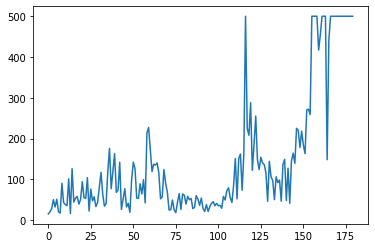

In [9]:
plt.plot(RewardStats)

In [10]:
test_rewards = []
for each_episode in range(10):
    obs = env.reset()
    done = False
    t=0
    total_reward = 0
    print("Episode : ", each_episode)

    while(not done):
        t += 1
        action = select_action(obs)
        obs, reward, done, _ = env.step(action)
        total_reward = total_reward + reward
        
    test_rewards.append(total_reward)
    print("Total Reward in this episode : ", total_reward)

Episode :  0
Total Reward in this episode :  500.0
Episode :  1
Total Reward in this episode :  500.0
Episode :  2
Total Reward in this episode :  500.0
Episode :  3
Total Reward in this episode :  500.0
Episode :  4
Total Reward in this episode :  500.0
Episode :  5
Total Reward in this episode :  386.0
Episode :  6
Total Reward in this episode :  500.0
Episode :  7
Total Reward in this episode :  500.0
Episode :  8
Total Reward in this episode :  412.0
Episode :  9
Total Reward in this episode :  500.0


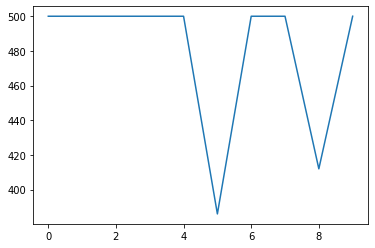

In [11]:
plt.plot(test_rewards)

In [12]:
from google.colab import files

torch.save(model, 'CartPole_A2C_Checkpoint.pth')
files.download('CartPole_A2C_Checkpoint.pth') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>